# Example : Higgs Boson
### Based on Tensorflow Documentation

In this example I will be helping to walk through a **practical example** and highlight the structure of a Tensorflow neural network. We will also be discussing L1, L2 and dropout as methods of improving the weights on your system. This is really a first step and there's a lot more to explore in the documentation as well as public repos. 

## Importing the Functions
This import will using "tfdocs" for a little bit of plotting. You can install this with the block below. 

In [1]:
import os
tf='tensorflow_docs'
try:
    import tensorflow_docs
    print("module",tf," is installed")
except ModuleNotFoundError:
    print("module ",tf," is not installed")
    os.system('pip install git+https://github.com/tensorflow/docs')


module tensorflow_docs  is installed


For Tensorflow, there is a subpackage called *keras* which handles the constructions of neural networks. 

In [55]:

#Machine Learning Imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers


#Plotting Imports
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from  IPython import display
from matplotlib import pyplot as plt

#Array manipulation
import numpy as np

#File manipulation
import pathlib
import shutil
import tempfile
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs" #Setting up the log ouput
shutil.rmtree(logdir, ignore_errors=True)

## The Higgs Dataset
* Data set of higgs sims from: https://arxiv.org/pdf/1402.4735.pdf 
* These are a set of momentum measurements for particles of a set decay channel. 
* The exact details are not tremendously important sufficen to say there is a background and a signal and both have been labeled in the simulation stage
* We can plot some of these features below (they have been mostly normalized)

We will be using a dataset provided by the software but if you want more datasets to experiment with then you can always looks at https://www.kaggle.com/datasets which provides some excellent datasets. See https://www.kaggle.com/datasets/pablomonleon/montreal-bike-lanes/code for a cool example. 

In [56]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

Here you will see how we import the data into the software. In this case our dataset is in a terrible format, a large compressed CSV file. This dataset also contains 28 features that we will be working with that we import here using an inbuilt routine. It's often easier to manipulate your data into a format where it's easier for the default routines to import it then trying to modify the routines. 

In [9]:
FEATURES = 28 
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1), compression_type="GZIP")

## Batches & Epochs

You will often break your data into smaller chunks called batches. These bataches are the number of training samples the network will move through before updating. This is different than epochs which is the total number of passes through the entire dataset the system takes. 

In this next little chunk we will use the batch function to selct a subset of the data.  We will then plot the data sorted into the two labels which determine whether something is signal or background

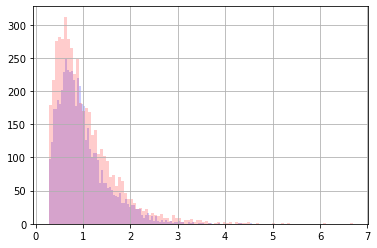

In [18]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

packed_ds = ds.batch(10000).map(pack_row).unbatch() #
for features,label in packed_ds.batch(10000).take(1):
    for i in range(1):#for i in range(FEATURES):
        plt.hist(features.numpy()[label.numpy().astype(bool),i].flatten(), bins = 101,color='blue',alpha=0.2)
        plt.hist(features.numpy()[~label.numpy().astype(bool),i].flatten(), bins = 101,color='red',alpha=0.2)
        plt.grid()
        plt.show()



## Sorting the Data
This data did not come in folder instead it came as a large csv, so we need to select the label and feature names. Here you can also see us sub divide the data into training and validation categories. Training data we will use to optimize the data and validation we will use to test. This should help us avoid issues of *overfitting*. You can also see us shuffle and batch the training data. 

In [36]:

N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 200
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE

validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()


validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Training procedure - Hyperparameter tuning and schedulers
* During training there are many parameters you can tune that shouldn't affect your final result but might affect the speed of the training or the ability to converge. These are called *hyperparameter*. 
* We also have a scheduler that will modify how we move through the dataset as we iterate through multiple passes. In this case we are using an inverse time delaym. It basically is saying that as we get closer to the answer it's better to take less dramatic changes to the weights.

In [37]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*100,
  decay_rate=1,
  staircase=False)


## Training and Fitting
* We will merge fitting and compiling in the same function. There are several options that we set prior to fitting to improve the visuals.
* We will use cross entropy and the adam optimizer https://arxiv.org/pdf/1412.6980.pdf
* We will also set-up a progress report so that we can track the system as it goes through the optimization.

In [38]:

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

def get_callbacks(name):
  return [
    #tfdocs.modeling.EpochDots(), #progress report
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200), #stop when not changing
    tf.keras.callbacks.TensorBoard(logdir/name), #some display functionaility
  ]

## Final Set-up
Here we are setting up the fit and also setting a history return so that as the system optimizes we can look back at the system to see how it evolved. 

In [39]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.losses.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=0)
  return history

### Tiny model
* We can set up different models of incresing complexity in order to model the data. This just needs to be a series of dense layers as the data is already properly formated. 
* Our idea is basically here we will start with a very simple neural network and increase the number of layers. 
* All of these will have the same activation function and will take input from our features. 
* We will then plot the validation and training Binary cross entropy (loss) over time. 

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


2023-10-19 11:26:26.124144: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:26:26.124187: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:26:26.125175: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:26:27.509624: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:26:27.509925: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:26:27.520187: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:26:27.522603: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:26:27.526007: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/sizes/Tiny/train/plugins/profile/2023_10_19_11_26_27

2023-10-19 11:

(0.5, 0.7)

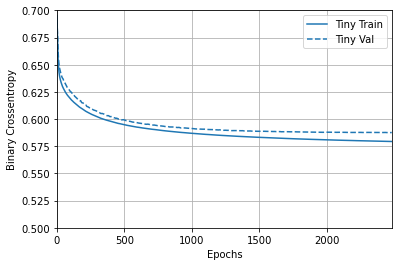

In [40]:
tiny_model = tf.keras.Sequential([
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(1)
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

In [41]:
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16)                464       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________


2023-10-19 11:31:48.674858: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:31:48.674912: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:31:48.675855: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:31:49.123312: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:31:49.123370: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:31:49.145146: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:31:49.147612: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:31:49.152011: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/sizes/Small/train/plugins/profile/2023_10_19_11_31_49

2023-10-19 11

### Medium model

In [42]:
medium_model = tf.keras.Sequential([
    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])
size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                1856      
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________


2023-10-19 11:33:16.920665: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:33:16.920699: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:33:16.920928: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:33:17.608513: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:33:17.608543: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:33:17.624156: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:33:17.626795: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:33:17.631340: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/sizes/Medium/train/plugins/profile/2023_10_19_11_33_17

2023-10-19 1

### Large model


In [43]:
large_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])
size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2023-10-19 11:33:54.065781: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:33:54.065834: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:33:54.065948: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:33:54.636464: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:33:54.636496: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:33:54.673133: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:33:54.676188: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:33:54.680930: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/sizes/large/train/plugins/profile/2023_10_19_11_33_54

2023-10-19 11

### Plot the training and validation losses
* What's going on in this plot? 
* We have the 4 basic models plotted here after they've fully run through the epochs. 
* We see a difference between validation and training, why?
* We see a difference between the different sizes of models at early and late training why?
* Which model performs the best, is this suprising?

Text(0.5, 0, 'Epochs [Log Scale]')

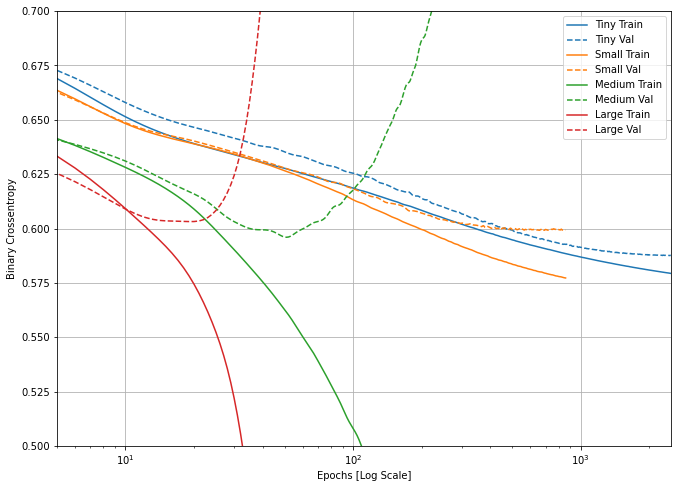

In [45]:
plt.figure(figsize=(11,8))
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")


## Strategies to prevent overfitting

* We will compare everything to the simple model. So let's save that. 
* We can try two things weight regularization, and dropout.

In [46]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

PosixPath('/tmp/tmps1qkh5c_/tensorboard_logs/regularizers/Tiny')

In [47]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## Weights
* L2 or L1? These are penalties to the weights based on how large the weights are (large weights normally mean overfitting) 
* We can penalized based on the absolute value or the square of the value. 
* L1 -> loss = l1 * reduce_sum(abs(x)) : Laso Regression
* L2 -> loss = l2 * reduce_sum(square(x)) : Ridge Regression


In [48]:
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_28 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________


2023-10-19 11:36:45.439735: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:36:45.439775: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:36:45.439891: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:36:45.997353: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:36:45.997383: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:36:46.024696: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:36:46.027228: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:36:46.030986: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/regularizers/l2/train/plugins/profile/2023_10_19_11_36_46

2023-10-1

(0.5, 0.7)

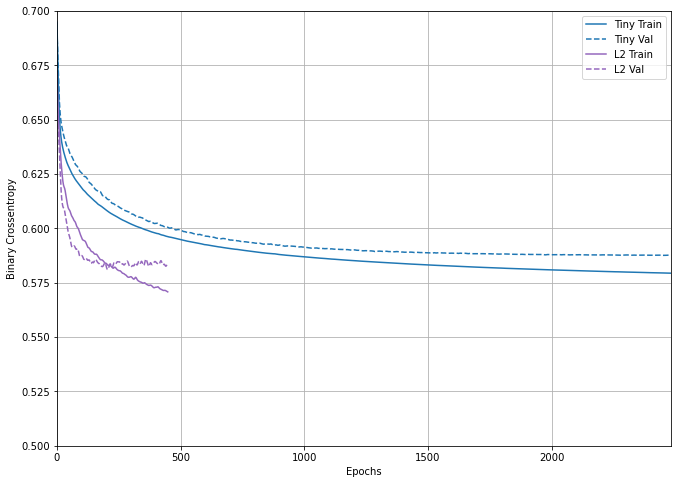

In [49]:
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Dropout
* Dropout is very effective way of removing overfitting
* Developed in Canada! 
* Usually 0.2 -> 0.5 (fraction of total features set to zero) 

In [50]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 512)             

2023-10-19 11:41:25.355953: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:41:25.355987: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:41:25.356894: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:41:25.855508: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:41:25.855535: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:41:25.886954: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:41:25.889331: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:41:25.893370: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/regularizers/dropout/train/plugins/profile/2023_10_19_11_41_25

2023

(0.5, 0.7)

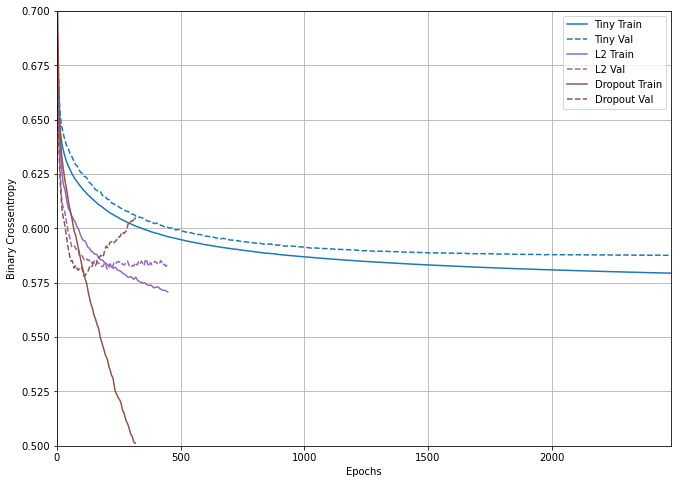

In [51]:
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

## Combining L2 + dropout
* Now let's put it all together and we will lower the power of the L2 regularization. 
* This is a final version of a well balanced and trained model which we could now use to identify types of particles. 

In [53]:
combined_model = tf.keras.Sequential([
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_42 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_44 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 512)             

2023-10-19 11:58:40.831801: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:58:40.831845: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:58:40.834243: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:58:41.548398: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-10-19 11:58:41.548436: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-10-19 11:58:41.594674: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-10-19 11:58:41.597493: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-10-19 11:58:41.602430: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: /tmp/tmps1qkh5c_/tensorboard_logs/regularizers/combined/train/plugins/profile/2023_10_19_11_58_41

202

(0.5, 0.7)

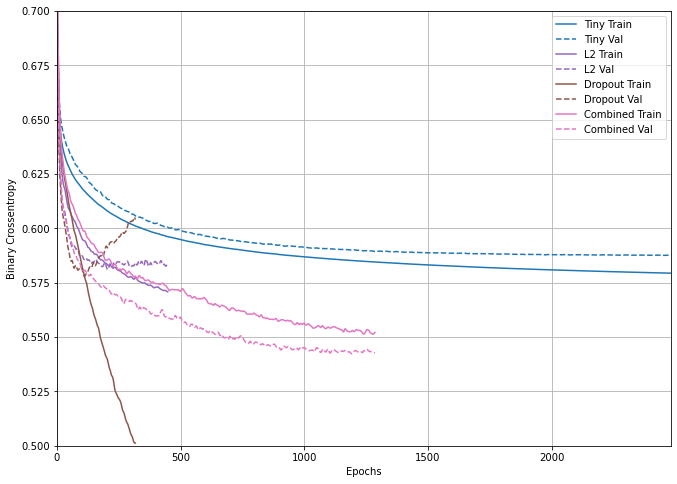

In [54]:
plt.figure(figsize=(11,8))
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

In [ ]:
# MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.
